In [1]:
#down pendulum EKF vs JRN comparison for 2 dimensions
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from numpy import linalg
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, lti, dlti, dstep
import scipy.integrate
import time
from mpl_toolkits import mplot3d
import matplotlib
from keras.callbacks import EarlyStopping
from keras.models import Sequential
#from keras.layers import Dense, SimpleRNN, LSTM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset  
import os

2025-06-27 14:10:21.557538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751047821.577856  288129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751047821.583928  288129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 14:10:21.603983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices())
start=time.time()

# Simulation variables
seq_length = 301 # Number of time steps in each sequence
num_records = 200 # Number of sequences to generate
dim_y = 1  # No. of observables
dim_x= 2 # Number of states
dt=0.1
end_t=seq_length*dt

# Arrays to store results
X_data_array = np.empty((num_records, seq_length, dim_x))
Y_data_array = np.empty((num_records, seq_length, dim_y))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [3]:
# Continuous-time model
def f(t,x,l,g,m,b):
    x1,x2=x
    dx_dt = [0,0]
    dx_dt[0] = x2
    dx_dt[1] = -(g*np.sin(x1))/l-b/m*x2
    return dx_dt

# Parameters
l=1
g=9.8 
m=2
b=0.9

P=0.01*np.identity(dim_x) #covariance of initial condition
mu_pn = np.zeros(dim_x) #mean of process noise
Q=0.01*np.identity(dim_x) #process noise covariance
mu_mn=np.zeros(dim_y) #mean of measurement noise
R=[0.01] #measurement noise covariance
G=np.identity(dim_x) #process noise coefficient matrix

t_span= np.arange(0,end_t,dt)
num_timesteps=np.shape(t_span)[0]

for i in range(0, num_records, 1):
    mu_x0=np.random.uniform(-2,2,size=dim_x) #mean of initial condition
    x0_old=np.random.multivariate_normal(mu_x0,P)
    sol=scipy.integrate.solve_ivp(f,(0,end_t),x0_old, method='RK45', args=(l,g,m,b),dense_output=True, t_eval=np.arange(0, end_t, dt))
    X_data_array[i,:,:]=np.transpose(sol.y)
    for j in range(1,seq_length,1):
        w=np.random.multivariate_normal(mu_pn,Q) 
        X_data_array[i,j,:]=X_data_array[i,j,:]+np.matmul(G,w)
        v=np.random.normal(mu_mn,R)   #change to multivariate if R has greater than 1 dimension
        Y_data_array[i,j,:]=np.matmul(X_data_array[i,j,:],[[1],[0]])+v
        

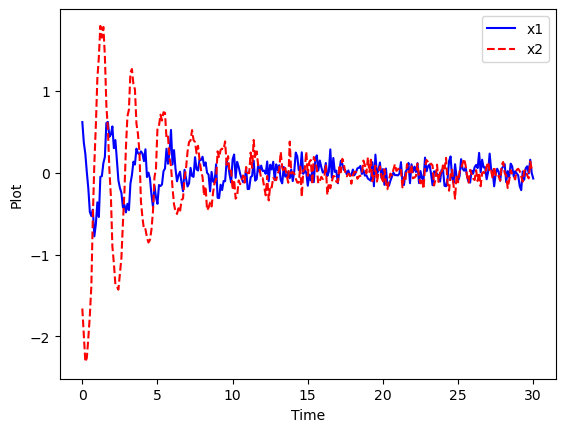

In [4]:
plt.plot(t_span,X_data_array[199,:,0],'b-',label='x1')
plt.plot(t_span,X_data_array[199,:,1],'r--',label='x2')
plt.ylabel('Plot')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

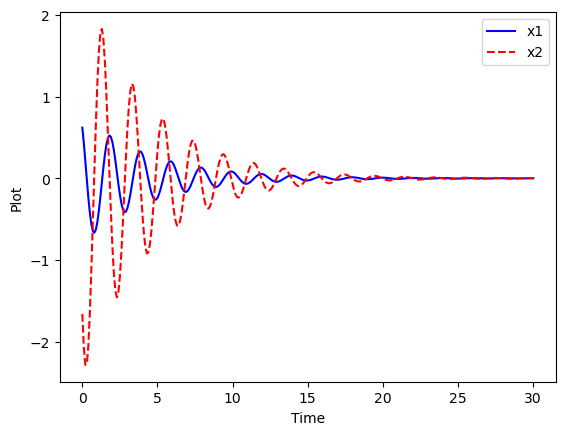

In [5]:
plt.plot(t_span,sol.y[0,:],'b-',label='x1')
plt.plot(t_span,sol.y[1,:],'r--',label='x2')
plt.ylabel('Plot')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

In [6]:
num_data_pts = seq_length*num_records
num_train_pts = np.floor(0.80*num_records).astype(int)
num_val_pts = np.floor(0.10*num_records).astype(int)
test_data_size = num_records-num_train_pts-num_val_pts

Y_train = Y_data_array[0:num_train_pts,1:,:]
X_train = X_data_array[0:num_train_pts,1:,:]
num_train_plus_val = num_train_pts+num_val_pts

Y_validate = Y_data_array[num_train_pts:num_train_plus_val,1:,:]
X_validate = X_data_array[num_train_pts:num_train_plus_val,1:,:]

Y_test = Y_data_array[num_train_plus_val:num_records,1:,:]
X_test = X_data_array[num_train_plus_val:num_records,1:,:]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Device name:", torch.cuda.get_device_name(0))
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# Convert data to PyTorch tensors
input_data = torch.tensor(Y_train, dtype=torch.float32)
output_data = torch.tensor(X_train, dtype=torch.float32)

# Define validation data
val_input_data = torch.tensor(Y_validate, dtype=torch.float32) 
val_output_data = torch.tensor(X_validate, dtype=torch.float32)  

test_input_data=torch.tensor(Y_test, dtype=torch.float32)
test_output_data=torch.tensor(X_test, dtype=torch.float32)

#proposed jrn implementation
start=time.time()

# Initialize variables for early stopping
best_val_loss = float('inf')  # Set initial best validation loss to infinity
patience = 50  # Number of epochs to wait for improvement
counter = 0  # Counter to track the number of epochs with no improvement

checkpoint_dir = './dp_torch_checkpoints_jrn'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the model
class JRN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(JRN, self).__init__()
        self.output_size=output_size 
        self.Why = nn.Parameter(torch.empty(hidden_size, output_size))
        nn.init.xavier_uniform_(self.Why)
        self.Wyh = nn.Parameter(torch.empty(output_size, hidden_size))
        self.Wxh = nn.Parameter(torch.empty(input_size, hidden_size))
        nn.init.orthogonal_(self.Wyh)  
        nn.init.orthogonal_(self.Wxh)
        #self.bh = nn.Parameter(torch.zeros(hidden_size))
        #self.by = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        y = torch.zeros(batch_size, self.output_size, device=x.device)
        outputs = []
        for i in range(seq_len):
            h = torch.tanh(torch.matmul(x[:, i, :], self.Wxh) + torch.matmul(y, self.Wyh))
            y = torch.matmul(h, self.Why) 
            outputs.append(y.unsqueeze(1))
        return torch.cat(outputs, dim=1)

# Create DataLoader for training data
train_dataset = TensorDataset(input_data, output_data)
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)

# Define the model, loss function, and optimizer
hidden_size = 50
model = JRN(dim_y, hidden_size, dim_x).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_epoch=0

# Training the model
num_epochs = 600
start_time = time.time()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_Y, batch_X in train_loader:
        batch_Y=batch_Y.to(device)
        batch_X=batch_X.to(device)
        # Forward pass
        all_outputs = model(batch_Y)

        # Compute the loss
        loss = criterion(all_outputs, batch_X)
        total_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_loss = criterion(model(val_input_data.to(device)), val_output_data.to(device))

    # Print and check for early stopping
    print(f'Epoch [{epoch}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_epoch = epoch
        torch.save({'model_state_dict': model.state_dict()}, os.path.join(checkpoint_dir, 'ckpt.pth'))
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.')
            break

end_time = time.time()
print("Time taken to train RNN:", end_time - start_time)

print("Best Epoch:", best_epoch)

# Restore best model
checkpoint = torch.load(os.path.join(checkpoint_dir, 'ckpt.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Test the model
with torch.no_grad():
    predicted_output = model(test_input_data.to(device))
    print("Error in Output:")
    print(predicted_output.to(device) - test_output_data.to(device))

Using device: cuda
Device name: NVIDIA RTX 4500 Ada Generation
Epoch [0], Loss: 0.2441, Val Loss: 0.2905
Epoch [1], Loss: 0.2395, Val Loss: 0.2856
Epoch [2], Loss: 0.2357, Val Loss: 0.2812
Epoch [3], Loss: 0.2323, Val Loss: 0.2771
Epoch [4], Loss: 0.2291, Val Loss: 0.2731
Epoch [5], Loss: 0.2260, Val Loss: 0.2690
Epoch [6], Loss: 0.2225, Val Loss: 0.2649
Epoch [7], Loss: 0.2191, Val Loss: 0.2605
Epoch [8], Loss: 0.2155, Val Loss: 0.2556
Epoch [9], Loss: 0.2115, Val Loss: 0.2500
Epoch [10], Loss: 0.2066, Val Loss: 0.2436
Epoch [11], Loss: 0.2012, Val Loss: 0.2360
Epoch [12], Loss: 0.1946, Val Loss: 0.2264
Epoch [13], Loss: 0.1859, Val Loss: 0.2142
Epoch [14], Loss: 0.1746, Val Loss: 0.1978
Epoch [15], Loss: 0.1592, Val Loss: 0.1750
Epoch [16], Loss: 0.1375, Val Loss: 0.1445
Epoch [17], Loss: 0.1129, Val Loss: 0.1137
Epoch [18], Loss: 0.0935, Val Loss: 0.0941
Epoch [19], Loss: 0.0778, Val Loss: 0.0719
Epoch [20], Loss: 0.0610, Val Loss: 0.0614
Epoch [21], Loss: 0.0531, Val Loss: 0.0530
E

/tmp/ipykernel_288129/122517588.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, 'ckpt.pth'))


In [8]:
# Output the final weight and bias values
print("Final Weight (Wxh):")
print(model.Wxh)
print("Final Weight (Wyh):")
print(model.Wyh)
print("Final Weight (Why):")
print(model.Why)

Final Weight (Wxh):
Parameter containing:
tensor([[ 0.2585, -0.1083,  0.1814,  0.1960,  0.1784,  0.1742,  0.2177,  0.2424,
          0.2246,  0.1741,  0.1679,  0.0923,  0.0951,  0.1504,  0.1491, -0.2626,
         -0.1758, -0.1275,  0.1204,  0.3295, -0.1347, -0.2708, -1.2969, -0.0062,
         -0.0376, -0.2145, -0.0910,  0.3701,  0.1301,  0.1556,  0.2442,  0.2872,
         -0.0344,  0.0071,  0.0085,  0.1528,  0.2031, -0.6047, -0.0816,  0.1779,
          0.2804, -0.0978,  0.0541, -0.1330,  0.2130,  0.2111, -0.0922, -0.1880,
         -0.1086, -0.0158]], device='cuda:0', requires_grad=True)
Final Weight (Wyh):
Parameter containing:
tensor([[ 0.2340, -0.1846,  0.0994, -0.1338, -0.1437,  0.2238, -0.0601, -0.0955,
          0.2050, -0.0552, -0.1587,  0.0982,  0.1133,  0.0066,  0.0780, -0.1957,
         -0.0222, -0.0672,  0.0863, -0.1887,  0.0191,  0.1658,  0.5638, -0.0472,
          0.1680,  0.2442, -0.0501, -0.1562,  0.0682,  0.1985,  0.0170, -0.0093,
          0.2004, -0.2590, -0.1126, -0.2

In [9]:
print(np.shape(predicted_output))
predicted_output=predicted_output.cpu()
predicted_output=predicted_output.numpy()
all_outputs=all_outputs.cpu()
all_outputs=all_outputs.detach().numpy()

torch.Size([20, 300, 2])


In [10]:
start3=time.time()
#implementing an EKF for down pendulum

def scalar(x):
    return np.squeeze(np.asarray(x)).item()
    
def gradient_f(z):
    df=np.matrix([[0,1],[-g*np.cos(scalar(z[0]))/l, -b/m]])
    return df

def funct(w):
    func_val=np.array([w[1],-((g*np.sin(w[0]))/l)-(b/m)*w[1]])
    return func_val


X_hat_t_ekf=np.zeros((test_data_size, seq_length, dim_x))#array to store estimated state values


def prediction(X_hat_t_1,P_t_1,Q_t):
    X_hat_t_initial=np.array(X_hat_t_1.reshape(-1)).flatten()
    
    solution=scipy.integrate.solve_ivp(f,(0,2*dt),X_hat_t_initial, method='RK45', args=(l,g,m,b),dense_output=True, t_eval=np.arange(0, 2*dt, dt))
    X_hat_t_new=solution.y[:,1]
    
    Id=np.eye(dim_x)
    X_hat_t=X_hat_t_new.reshape(-1,1)
    
    F_t=Id+(1/6)*((dt*gradient_f(X_hat_t))+(2*dt*gradient_f(X_hat_t+(dt/2)*funct(X_hat_t))*(Id+(dt/2)*gradient_f(X_hat_t)))+(2*dt*gradient_f(X_hat_t+(dt/2)*funct(X_hat_t+(dt/2)*funct(X_hat_t)))*(Id+(dt/2)*gradient_f(X_hat_t+(dt/2)*funct(X_hat_t)))*(Id+(dt/2)*gradient_f(X_hat_t)))+(dt*gradient_f(X_hat_t+dt*funct(X_hat_t+(dt/2)*funct(X_hat_t+(dt/2)*funct(X_hat_t))))*(Id+dt*gradient_f(X_hat_t+(dt/2)*funct(X_hat_t+(dt/2)*funct(X_hat_t))))*(Id+(dt/2)*gradient_f(X_hat_t+(dt/2)*funct(X_hat_t)))*(Id+(dt/2)*gradient_f(X_hat_t)))) 
    P_t = F_t*P_t_1*F_t.T + Q_t
    
    return X_hat_t,P_t

def update(X_hat_t,P_t,Y_t,R_t):
    H_t=np.matrix([[1,0]])

    S = H_t*P_t*H_t.T + R_t

    K = (P_t*H_t.T) /S

    z = Y_t - (H_t*X_hat_t)         
    X_t = X_hat_t + (K*z)

    P_t = P_t - (K*H_t*P_t)

    return X_t,P_t

for seq in range(0, test_data_size, 1):
    
    P_t_minus_1=np.matrix([[0.01,0],[0,0.01]])
    Q_t=np.matrix([[0.01,0],[0,0.01]])
    R_t=np.matrix([[0.01]])
    
    #mu_x0_approx=np.random.uniform(-2,2,size=dim_x) #mean of initial condition
    #X_hat_t_ekf[seq,0,:]=np.random.multivariate_normal(mu_x0,P)
    for timestep in range(1, seq_length, 1):

        X_hat_t_step=np.transpose(np.matrix(X_hat_t_ekf[seq,timestep-1,:]))
        Y_t_step=np.matrix(Y_test[seq,timestep-1,:])

        X_hat_t_step,P_hat_t=prediction(X_hat_t_step,P_t_minus_1,Q_t)

        X_t,P_t=update(X_hat_t_step,P_hat_t,Y_t_step,R_t)

        X_hat_t_ekf[seq,timestep,:]=np.squeeze(np.asarray(X_t))

        P_t_minus_1=P_t  
        
end3=time.time()
print(end3-start3)

3.800093173980713


In [31]:
#for plotting absolute error at each timestep averaged over test sequences
test_errors_for_ekf=np.zeros((seq_length-1,1))
for k in range(0,seq_length-1,1):
    for i in range(0,test_data_size,1):
        for j in range(0, dim_x, 1):
            test_errors_for_ekf[k]+=(X_hat_t_ekf[i,k+1,j]-X_test[i,k,j])**2
test_errors_for_ekf=test_errors_for_ekf/(dim_x*test_data_size)


In [32]:
#for plotting absolute error at each timestep averaged over test sequences
test_errors_for_jrn=np.zeros((seq_length-1,1))
for k in range(0,seq_length-1,1):
    for i in range(0,test_data_size,1):
        for j in range(0, dim_x, 1):
            test_errors_for_jrn[k]+=(predicted_output[i,k,j]-X_test[i,k,j])**2
test_errors_for_jrn=test_errors_for_jrn/(dim_x*test_data_size)

In [34]:
# Compute squared error
jrn_squared_error = (predicted_output - X_test) ** 2

# Compute mean squared error over all samples, timesteps, and dimensions
jrn_mse = np.mean(jrn_squared_error)

# Root mean squared error
jrn_rmse = np.sqrt(jrn_mse)

print(f"JRN RMSE: {jrn_rmse}")

JRN RMSE: 0.1700305612913123


In [35]:
# Extract test portion of X_hat_t_ekf
X_hat_test = X_hat_t_ekf[:, 1:, :] 

# Compute squared error
ekf_squared_error = (X_hat_test - X_test) ** 2

# Compute mean squared error across all samples, timesteps, and dimensions
ekf_mse = np.mean(ekf_squared_error)

# Root mean squared error
ekf_rmse = np.sqrt(ekf_mse)

print(f"EKF RMSE: {ekf_rmse}")

EKF RMSE: 0.19207615315483295


In [36]:
print(best_epoch)

598


In [43]:
H = np.array([1, 0])  # measurement matrix, shape (n,)

def f(t,x):
    x1,x2=x
    dx_dt = [0,0]
    dx_dt[0] = x2
    dx_dt[1] = -(g*np.sin(x1))/l-b/m*x2
    return dx_dt
    
start4= time.time()
def generate_sigma_points(x, P, alpha=1e-3, beta=2, kappa=0):
    n = x.shape[0]
    lambda_ = alpha**2 * (n + kappa) - n
    c = n + lambda_
    Wm = np.full(2 * n + 1, 0.5 / c)
    Wc = np.full(2 * n + 1, 0.5 / c)
    Wm[0] = lambda_ / c
    Wc[0] = lambda_ / c + (1 - alpha**2 + beta)

    U = np.linalg.cholesky(c * P)
    sigma_points = np.zeros((2 * n + 1, n))
    sigma_points[0] = x
    for i in range(n):
        sigma_points[i + 1] = x + U[:, i]
        sigma_points[n + i + 1] = x - U[:, i]
    return sigma_points, Wm, Wc

def unscented_transform(sigma_points, Wm, Wc, noise_cov):
    # For state (vector) sigma points
    mean = np.sum(Wm[:, None] * sigma_points, axis=0)  # shape (n,)
    diff = sigma_points - mean
    cov = np.zeros((mean.size, mean.size))
    for i in range(len(sigma_points)):
        cov += Wc[i] * np.outer(diff[i], diff[i])
    cov += noise_cov
    return mean, cov

def unscented_transform_meas(sigma_points, Wm, Wc, noise_cov):
    # For scalar measurement sigma points
    mean = np.sum(Wm * sigma_points)  # scalar
    diff = sigma_points - mean
    cov = np.sum(Wc * diff * diff) + noise_cov  # scalar
    return mean, cov

dt = 0.1

def ukf_predict(x, P, Q):
    sigma_points, Wm, Wc = generate_sigma_points(x, P)
    
    propagated_sigma = []
    for sp in sigma_points:
        sol = scipy.integrate.solve_ivp(f, [0, dt], sp, method='RK45', t_eval=[dt])
        propagated_sigma.append(sol.y[:, -1])
    propagated_sigma = np.array(propagated_sigma)  
    
    x_pred, P_pred = unscented_transform(propagated_sigma, Wm, Wc, Q)
    return x_pred, P_pred, propagated_sigma, Wm, Wc

def ukf_update(x_pred, P_pred, propagated_sigma, Wm, Wc, y, R):
    meas_sigma = propagated_sigma @ H  
    
    y_pred, P_yy = unscented_transform_meas(meas_sigma, Wm, Wc, R)
    
    P_xy = np.zeros((x_pred.size, 1))
    for i in range(len(propagated_sigma)):
        dx = propagated_sigma[i] - x_pred   # (n,)
        dy = meas_sigma[i] - y_pred         # scalar
        P_xy += Wc[i] * dx[:, None] * dy   # (n,1)
    
    K = P_xy / P_yy                        # Kalman gain (n,1)
    
    x_new = x_pred + K.flatten() * (y - y_pred)
    P_new = P_pred - (K * P_yy) @ K.T
    return x_new, P_new

x_t = np.array([0.0, 0.0])
P_t = P            

X_hat_ukf = np.zeros((test_data_size, seq_length, dim_x))
X_hat_ukf[:,0,:] = x_t

for i in range(0, test_data_size, 1):
    for t in range(1, seq_length):
        # Prediction step
        x_pred, P_pred, propagated_sigma, Wm, Wc = ukf_predict(x_t, P_t, Q)
        y_t = Y_test[i,t-1,:]
        
        # Update step
        x_t, P_t = ukf_update(x_pred, P_pred, propagated_sigma, Wm, Wc, y_t, R)
        X_hat_ukf[i,t,:] = x_t

print("UKF estimation done.")

end4=time.time()
print("Time taken to run UKF:", end4-start4)

UKF estimation done.
Time taken to run UKF: 10.404922246932983


In [44]:
X_hat_test_ukf = X_hat_ukf[:, 1:, :]
ukf_squared_error = (X_hat_test_ukf - X_test) ** 2
ukf_rmse = np.sqrt(np.mean(ukf_squared_error))
print(f"UKF RMSE: {ukf_rmse}")

UKF RMSE: 0.20243318749172542


In [45]:
#for plotting absolute error at each timestep averaged over test sequences
test_errors_for_ukf=np.zeros((seq_length-1,1))
for k in range(0,seq_length-1,1):
    for i in range(0,test_data_size,1):
        for j in range(0, dim_x, 1):
            test_errors_for_ukf[k]+=(X_hat_ukf[i,k+1,j]-X_test[i,k,j])**2
test_errors_for_ukf=test_errors_for_ukf/(dim_x*test_data_size)

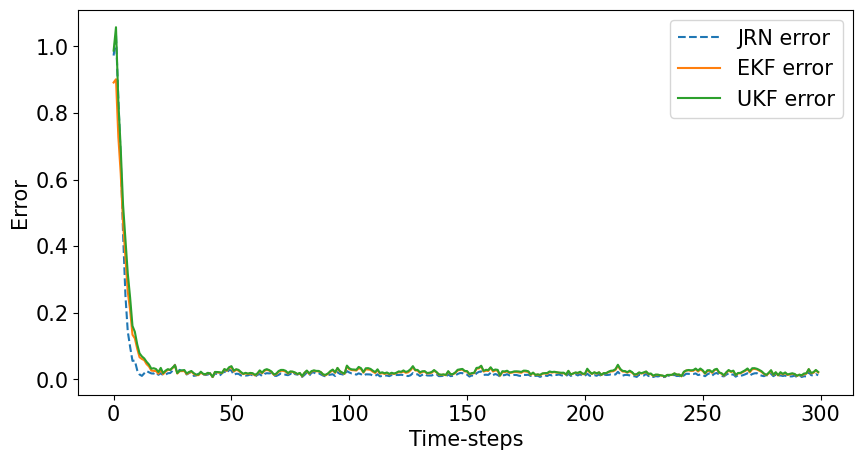

In [46]:
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

t2=[i for i in range(0,seq_length-1, 1)] #change timesteps here if needful
f1=plt.figure()
f1.set_figwidth(10)
f1.set_figheight(5)
plt.plot(t2,test_errors_for_jrn[:,:],label="JRN error",linestyle='dashed')
plt.plot(t2,test_errors_for_ekf[:,:],label="EKF error")
plt.plot(t2,test_errors_for_ukf[:,:],label="UKF error")
#plt.title(f"x{i+1}")
plt.xlabel("Time-steps", fontsize=15)
#plt.xlim(0,100)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
plt.show()
f1.savefig("downpendulum_errors.png")
f1.savefig("downpendulum_errors.svg")

In [48]:
print(f"UKF RMSE: {ukf_rmse}")
print(f"EKF RMSE: {ekf_rmse}")
print(f"JRN RMSE: {jrn_rmse}")
print(f"Best Epoch: {best_epoch}")

UKF RMSE: 0.20243318749172542
EKF RMSE: 0.19207615315483295
JRN RMSE: 0.1700305612913123
Best Epoch: 598


In [49]:
np.savez("downpendseq_data.npz", X_data=X_data_array[:,:,:], Y_data=Y_data_array[:,:,:])